<a href="https://colab.research.google.com/github/johnwiese/pneumonia-prediction-transferlearning/blob/master/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using the kaggle dataset chest-xray-pneumonia.zip implement a Pneumonia detector. Uses transfer learning, Keras, Tensorflow. Transfer learning is based on the InceptionV3.

In [0]:
import os
import numpy as np
from pathlib import Path


Configure some parameters


In [0]:
height = 299 
width = 299   #image input size

base_dir = "./drive/My Drive/ML/WK4"
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

Setup the InceptionV3 prior trained model to use for transfer learning


Load our data from the Kaggle data: chest-xray-pneumonia.zip 
Data is loaded locally on Google Drive 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pwd
!ls -al


/content
total 20
drwxr-xr-x 1 root root 4096 Sep 28 20:26 .
drwxr-xr-x 1 root root 4096 Sep 28 20:06 ..
drwxr-xr-x 1 root root 4096 Sep 18 16:07 .config
drwx------ 3 root root 4096 Sep 28 20:25 drive
drwxr-xr-x 1 root root 4096 Aug 27 16:17 sample_data


In [5]:
%cd "./drive/My Drive/ML/WK4"
!ls -al

/content/drive/My Drive/ML/WK4
total 2678307
drwx------ 2 root root       4096 Sep 20 19:52 chest_xray
-rw------- 1 root root 1236184657 Sep 20 19:22 chest-xray-pneumonia.zip
-rw------- 1 root root 1237249419 Mar 24  2018 chest_xray.zip
drwx------ 2 root root       4096 Sep 20 19:52 __MACOSX
-rw------- 1 root root  269142640 Sep 21 21:21 pneumonia.h5


In [0]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!ls -al
!unzip chest_xray.zip

total 2678307
drwx------ 2 root root       4096 Sep 20 19:52 chest_xray
-rw------- 1 root root 1236184657 Sep 20 19:22 chest-xray-pneumonia.zip
-rw------- 1 root root 1237249419 Mar 24  2018 chest_xray.zip
drwx------ 2 root root       4096 Sep 20 19:52 __MACOSX
-rw------- 1 root root  269142640 Sep 21 21:21 pneumonia.h5
Archive:  chest_xray.zip
replace chest_xray/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/chest_xray/test/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOS

In [7]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [8]:
# setup keras callbacks for various options: Learning rate, etc
#from keras import callbacks
#cbks = [callbacks.LearningRateScheduler(lambda x: 1. / (1. + x))]

rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [14]:
print("Summary")
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  m = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  m.summary()
  return m

model = get_model()


Summary








87916544/87910968 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
___________

In [15]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Now setup for transfer learning. Constuct a new top layer.

# Setup for Training new model for Pneumonia

# Train the model

In [16]:
print('Start model training')


model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Start model training

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
163/163 [==============================] - 114s 699ms/step - loss: 0.3911 - acc: 0.8597 - val_loss: 2.8222 - val_acc: 0.4696
Epoch 2/5
163/163 [==============================] - 103s 631ms/step - loss: 0.2632 - acc: 0.8932 - val_loss: 1.9508 - val_acc: 0.7212
Epoch 3/5
163/163 [==============================] - 103s 632ms/step - loss: 0.2506 - acc: 0.8982 - val_loss: 1.4109 - val_acc: 0.7308
Epoch 4/5
163/163 [==============================] - 105s 645ms/step - loss: 0.2501 - acc: 0.8993 - val_loss: 1.1493 - val_acc: 0.7115
Epoch 5/5
163/163 [==============================] - 104s 640ms/step - loss: 0.2357 - acc: 0.9045 - val_loss: 1.1104 - val_acc: 0.7035


In [0]:
model.save('pneumonia.h5')

#  Model Prediction

In [18]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 1s 67ms/step
Loss: 1.3301522696083978
Accuracy: 0.75


In [22]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0])]

# Plotting images

Functions for plotting and prediction results

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1
  

Plot Normal and Pneumonia images

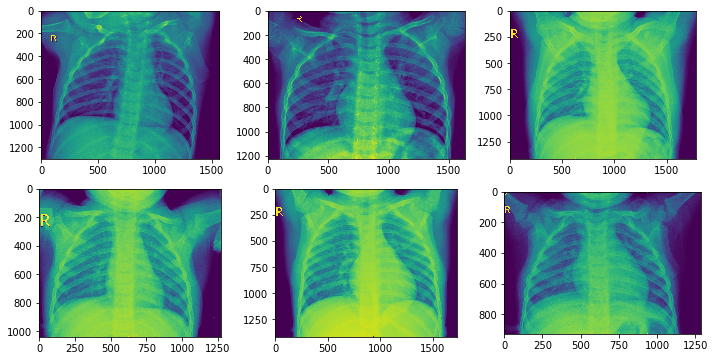

In [24]:
plot_images(test_dir + '/NORMAL')

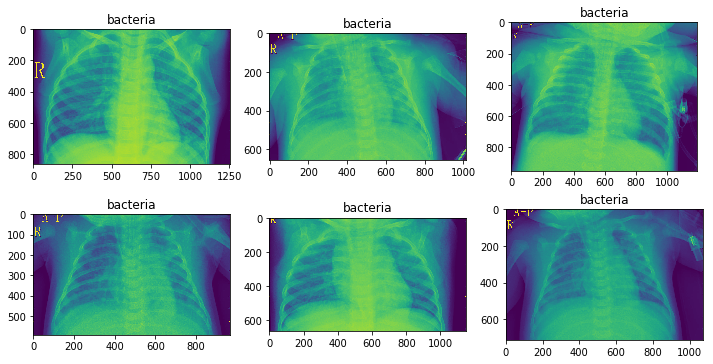

In [25]:
plot_images(test_dir + '/PNEUMONIA', labeled=True)

# Loading Model - Call as needed for testing cases after trained

In [0]:
new_model = keras.models.load_model('pneumonia.h5')